## Notebook setup

In [39]:
library(tidyverse)
library(patchwork)
library(arcadiathemeR)

In [4]:
setwd("..")

In [41]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)

## Constants for plotting set up

In [2]:
REGULAR_FONT <- "Suisse Int'l"
CATEGORICAL_FONT <- REGULAR_FONT
LILAC <- c("#6862AB")
BLOSSOM <- c("#F4CAE3")
CLOUD <- c("#ABBAC4")

## Read in data

In [8]:
metadata <- read_tsv("benchmarking_data/controls/control_metadata.tsv", show_col_types = FALSE) %>%
  mutate(structure_file = str_remove(string = structure_file, pattern = ".pdb"))

In [25]:
column_types <- cols(.default = col_character(), qlen = col_double(), tlen = col_double(),
                     alnlen = col_double(), alntmscore = col_double(), qtmscore = col_double(),
                     ttmscore = col_double(), lddt = col_double(), prob = col_double(),
                     qcov = col_double(), tcov = col_double(), pident = col_double(),
                     bits = col_double(), evalue = col_double(), qstart = col_double(),
                     qend = col_double(), tstart = col_double(), tend = col_double(),
                     proteinatlas_chromosome = col_character(),
                     host_fragment = col_logical(), host_redox_potential = col_logical(),
                     host_temperature_dependence = col_logical(), host_fragment_1 = col_logical(),
                     host_gene_encoded_by = col_logical())

In [26]:
results <- Sys.glob("outputs/human/foldseek/*/processed/*tmscorethreshold0.5*tsv") %>%
  set_names() %>%
  map_dfr(~ read_tsv(.x, col_types = column_types, show_col_types = FALSE), .id = "filepath") %>%
  mutate(filepath = str_remove(string = filepath, pattern = "outputs/human/foldseek/"),
         filepath = str_remove(string = filepath, pattern = "processed/foldseek_"),
         filepath = str_remove(string = filepath, pattern = "_tmalignfast0_exacttmscore1_tmscorethreshold0.5.tsv")) %>%
  separate(col = filepath, into = c("mimic", "alignment_type"), sep = "/", remove = TRUE) %>%
  mutate(alignment_type = ifelse(alignment_type == "alignmenttype1", "TM-align", "3Di+AA")) %>%
  left_join(metadata, by = c("query" = "structure_file"))

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“The following named parsers don't match the column names: qlen, tlen, alnlen, alntmscore, qtmscore, ttmscore, lddt, prob, qcov, tcov, pident, bits, evalue, qstart, qend, tstart, tend, proteinatlas_chromosome, host_fragment, host_redox_potential, host_temperature_dependence, host_fragment_1, host_gene_encoded_by”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“The following named parsers don't match the column names: qlen, tlen, alnlen, alntmscore, qtmscore, ttmscore, lddt, prob, qcov, tcov, pident, bits, evalue, qstart, qend, tstart, tend, proteinatlas_chromosome, host_fragment, host_redo

## Make plots

In [32]:
plt_a <- ggplot(results, aes(x = alnlen, fill = alignment_type)) +
  geom_histogram(bins = 200) +
  theme_arcadia() +
  theme(legend.text = ggplot2::element_text(family = CATEGORICAL_FONT, size = 15),
        legend.position = "inside",
        legend.position.inside = c(0.75, 0.55)) +
  labs(x = "Alignment length", y = "Observed count", fill = "Alignment type") +
  scale_y_sqrt() +
  scale_x_sqrt() +
  scale_fill_manual(values = c(LILAC, BLOSSOM))

In [36]:
plt_b <- ggplot(results %>% filter(alignment_type == "3Di+AA"), 
        aes(x = alnlen, y = qtmscore, color = alignment_type)) +
  geom_point(alpha = 0.1) +
  geom_vline(xintercept = 20, linetype = "dashed", color = CLOUD) +
  geom_hline(yintercept = 0.15, linetype = "dashed", color= CLOUD) +
  theme_arcadia() +
  theme(legend.position = "None") +
  labs(x = "Alignment length", y = "Query TM-score", color = "Alignment type") +
  scale_color_manual(values = c(LILAC)) +
  scale_y_sqrt() +
  scale_x_sqrt()

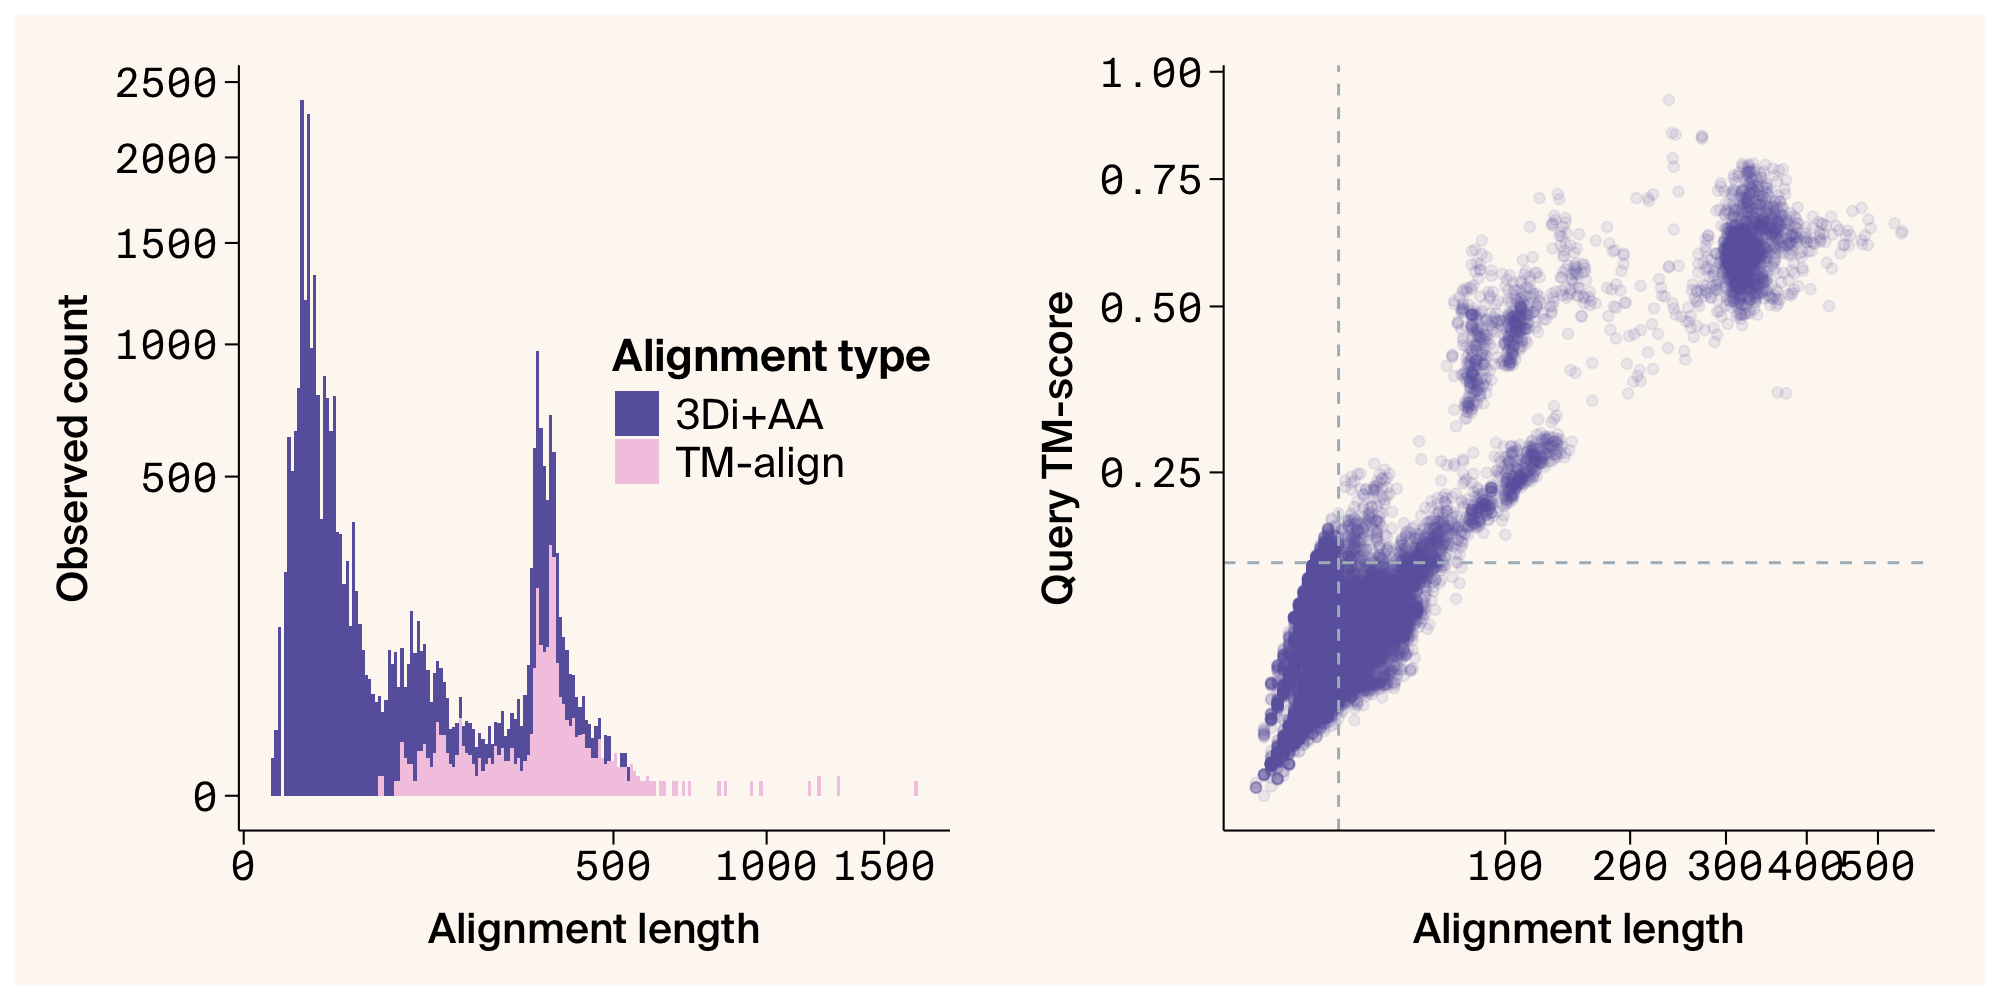

In [42]:
combined_plt <- plt_a + plt_b
combined_plt

In [ ]:
arcadiathemeR::save_arcadia_plot(filepath = "figures/fig2-foldseek-full-wide", plot = combined_plt,
                                 panel_size = "float_wide", formats=c("pdf", "png"))

## Table summarizing results

In [43]:
results %>%
  group_by(alignment_type) %>%
  summarize(min_qtmscore = min(qtmscore),
            min_ttmscore = min(ttmscore),
            min_alntmscore = min(alntmscore))

alignment_type,min_qtmscore,min_ttmscore,min_alntmscore
<chr>,<dbl>,<dbl>,<dbl>
3Di+AA,0.009302,0.002982,0.40283217
TM-align,0.500300,0.040100,0.06227997


## Calculate for raw foldseek results (where alntmscore is not corrected)

In [46]:
column_types <- cols(.default = col_character(),
                     qlen = col_double(), tlen = col_double(),
                     alnlen = col_double(), alntmscore = col_double(),
                     qtmscore = col_double(), ttmscore = col_double(),
                     lddt = col_double(), prob = col_double(),
                     qcov = col_double(), tcov = col_double(),
                     pident = col_double(), bits = col_double(),
                     evalue = col_double(), qstart = col_double(),
                     qend = col_double(), tstart = col_double(),
                     tend = col_double())

In [48]:
results <- Sys.glob("outputs/human/foldseek/*/raw/*tmscorethreshold0.5*tsv") %>%
  set_names() %>%
  map_dfr(~ read_tsv(.x, col_types = column_types, show_col_types = FALSE), .id = "filepath") %>%
  mutate(filepath = str_remove(string = filepath, pattern = "outputs/human/foldseek/"),
         filepath = str_remove(string = filepath, pattern = "raw/foldseek_"),
         filepath = str_remove(string = filepath, pattern = "_tmalignfast0_exacttmscore1_tmscorethreshold0.5.tsv")) %>%
  separate(col = filepath, into = c("mimic", "alignment_type"), sep = "/", remove = TRUE) %>%
  mutate(alignment_type = ifelse(alignment_type == "alignmenttype1", "TM-align", "3Di+AA")) %>%
  left_join(metadata, by = c("query" = "structure_file"))

In [49]:
results %>%
  group_by(alignment_type) %>%
  summarize(min_qtmscore = min(qtmscore),
            min_ttmscore = min(ttmscore),
            min_alntmscore = min(alntmscore))

alignment_type,min_qtmscore,min_ttmscore,min_alntmscore
<chr>,<dbl>,<dbl>,<dbl>
3Di+AA,0.009302,0.002982,0.5000
TM-align,0.500300,0.040100,0.5042


In [50]:
sessionInfo()

R version 4.4.3 (2025-02-28)
Platform: x86_64-apple-darwin13.4.0
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/tidyjupyter/lib/libopenblasp-r0.3.29.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] patchwork_1.3.0     arcadiathemeR_0.1.0 lubridate_1.9.4    
 [4] forcats_1.0.0       stringr_1.5.1       dplyr_1.1.4        
 [7] purrr_1.0.4         readr_2.1.5         tidyr_1.3.1        
[10] tibble_3.2.1        ggplot2_3.5.2       tidyverse_2.0.0    

loaded via a namespace (and not attached):
 [1] bit_4.6.0         gtable_0.3.6      jsonlite_2.0.0    compiler_4.4.3   
 [5] crayon_1.5.3      tidyselect_1.2.1  IRdisplay_1.1     parallel_4.4.3   
 [9] snakecase_0.11.1  scales_1.3.0  